In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and check table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Display column names and data types for Measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Display column names and data types for Station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date

('2017-08-23')

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.date(2017, 8, 23)
query_date = most_recent_date - dt.timedelta(days = 365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
last_year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql_query(last_year_precip, session.bind)

precip_df.set_index('date', inplace = True)
precip_df.head()

2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-21,0.02
2017-08-21,NaN
2017-08-21,0.56


In [25]:
# Drop null values
clean_precip_df = precip_df.dropna()
clean_precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-22,0.50
2017-08-23,0.00


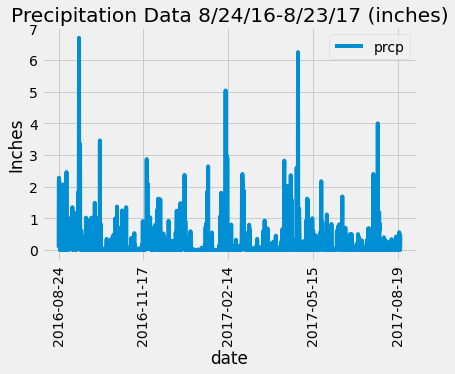

In [79]:
clean_precip_df.plot(y = 'prcp', rot = 90)
plt.title("Precipitation Data 8/24/16-8/23/17 (inches)")
plt.ylabel("Inches")
plt.show()

### Summary Statistics

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} unique stations in our dataset.")

There are 9 unique stations in our dataset.


In [81]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
observation_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

for station in observation_counts:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [87]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stn = 'USC00519281'

most_active_summary = session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp)).\
    filter(Measurement.station == most_active_stn).\
    all()
min_prcp = most_active_summary[0][0]
max_prcp = most_active_summary[0][1]
avg_prcp = most_active_summary[0][2]

print(f"The minimum ")

0.0


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [29]:
# Close Session
session.close()